In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Projects/mwp_enhanced/modeling2
# Install and Load Libraries

Mounted at /content/drive
/content/drive/MyDrive/Projects/mwp_enhanced/modeling2


In [ ]:

!pip install yahoo-fin
!pip install hvplot
!pip install pandas-ta
# url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
# !curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
# url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py39hd257fcd_4.tar.bz2'
# !curl -L $url | tar xj -C /usr/local/lib/python3.9/dist-packages/ lib/python3.9/site-packages/talib --strip-components=3
!pip install pycaret
!pip install pycaret[tuners]
!pip install "schemdraw<0.16"
!pip install mlflow --quiet
!pip install mplfinance
!pip install python-dotenv
# import modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import panel as pn
pn.extension('tabulator')
import pandas as pd

from panel.template import FastListTemplate
from pathlib import Path
from yahoo_fin.stock_info import get_data
import datetime
from matplotlib.figure import Figure
from matplotlib import cm
%matplotlib inline

# import modules that help build tabs
import modules.helpers as helpers
import modules.HistoricalData as hst
import modules.MCTab as MCTab
import modules.intro as intro
import modules.profile as prf
import modules.AlgoTab as at

import pandas_ta as ta
# import talib
# from yahoo_finance_api2 import share
import numpy as np
# import mplfinance as mpf

from joblib import dump, load
from pycaret.classification import *

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import mlflow
from getpass import getpass
from sklearn.model_selection import train_test_split
from dotenv import load_dotenv

from sklearn.metrics import brier_score_loss
from sklearn.ensemble import GradientBoostingClassifier
!pip install scikit-optimize
from skopt import BayesSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from lightgbm import LGBMClassifier

load_dotenv()


In [3]:
X_train = pd.read_csv(Path("./data/prepared/Xtrain.csv"))
X_test = pd.read_csv(Path("./data/prepared/Xtest.csv"))
y_train = pd.read_csv(Path("./data/prepared/ytrain.csv"))
y_test = pd.read_csv(Path("./data/prepared/ytest.csv"))
X_validation = pd.read_csv(Path("./data/prepared/Xvalidation.csv"))
y_validation = pd.read_csv(Path("./data/prepared/yvalidation.csv"))

# Model Training

### Define scaler to use in model training

In [11]:
scaler = MinMaxScaler()

## Gradient Boosting Classifier Training

In [12]:

gbc = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.003944321219069253, loss='log_loss',
                           max_depth=10, max_features=0.886727525845163,
                           max_leaf_nodes=None,
                           min_impurity_decrease=0.12030146051293354,
                           min_samples_leaf=1, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=287,
                           n_iter_no_change=None, random_state=123,
                           subsample=0.9265771876529256, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [13]:
pipeline = Pipeline(steps=[("scaler", scaler), ("gbc", gbc)])

In [14]:
gbc_model = pipeline.fit(X_train, y_train)

In [15]:
dump(gbc_model, Path("./models/gbc_model.joblib"))

['models/gbc_model.joblib']

## LightGBM Training

In [16]:

lgbm = LGBMClassifier(bagging_fraction=0.7078750819469858, bagging_freq=2,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.6682470001755085, importance_type='split',
               learning_rate=0.011908256456919489, max_depth=-1,
               min_child_samples=62, min_child_weight=0.001,
               min_split_gain=0.6870042099013675, n_estimators=209, n_jobs=-1,
               num_leaves=62, objective=None, random_state=123,
               reg_alpha=1.5754585952727133e-07,
               reg_lambda=8.304171871667417e-08, silent='warn', subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [17]:
pipeline = Pipeline(steps=[("scaler", scaler), ("lgbm", lgbm)])

In [18]:
lgbm_model = pipeline.fit(X_train, y_train)

[LightGBM] [Warning] bagging_fraction is set=0.7078750819469858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7078750819469858
[LightGBM] [Warning] feature_fraction is set=0.6682470001755085, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6682470001755085
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


In [19]:
dump(lgbm_model, Path("./models/lgbm_model.joblib"))

['models/lgbm_model.joblib']

# Model Evaluations

## Gradient Boosting Classifier

### Test Data Metrics

In [66]:
gbc_preds = gbc_model.predict(X_test)
gbc_proba = gbc_model.predict_proba(X_test)

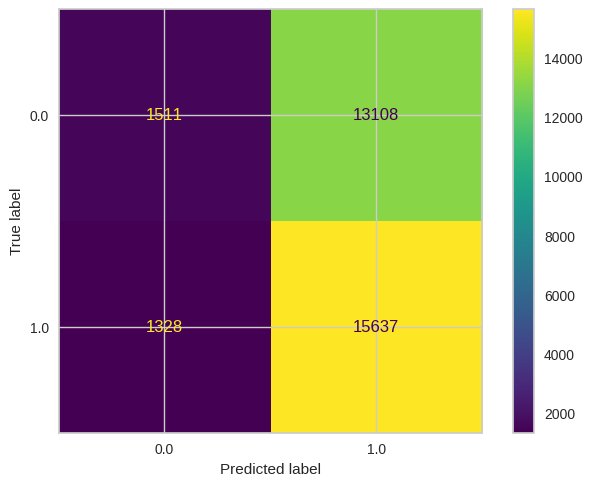

In [67]:
ConfusionMatrixDisplay.from_predictions(y_test, gbc_preds);

In [69]:
print(classification_report(y_test, gbc_preds))

              precision    recall  f1-score   support

         0.0       0.53      0.10      0.17     14619
         1.0       0.54      0.92      0.68     16965

    accuracy                           0.54     31584
   macro avg       0.54      0.51      0.43     31584
weighted avg       0.54      0.54      0.45     31584



In [53]:
gbc_threshold_review = y_test.copy()
gbc_threshold_review['proba'] = gbc_proba[:,1].tolist()
gbc_threshold_review['pred'] = gbc_preds.tolist()

Review the probability spread for misclassified predictions

In [62]:
gbc_threshold_review[(gbc_threshold_review['pred'] == 1) & (gbc_threshold_review['target'] == 0)]['proba'].describe()

count    13108.000000
mean         0.534176
std          0.029315
min          0.500011
25%          0.518607
50%          0.527190
75%          0.539713
max          0.813034
Name: proba, dtype: float64

### Validation Data Metrics

In [60]:
gbc_preds_val = gbc_model.predict(X_validation)
gbc_proba_val = gbc_model.predict_proba(X_validation)

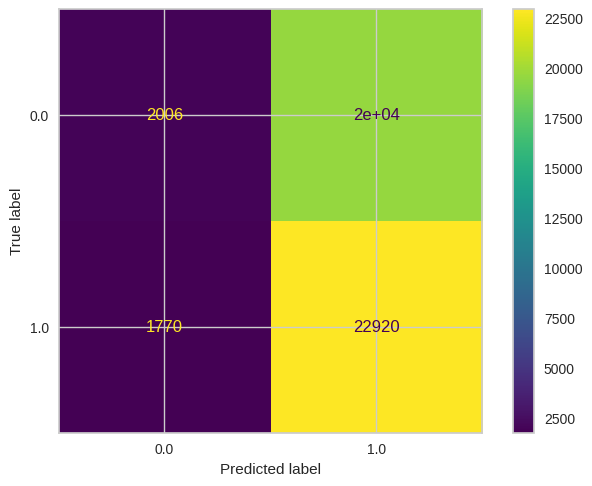

In [61]:
ConfusionMatrixDisplay.from_predictions(y_validation, gbc_preds_val);

In [71]:
print(classification_report(y_validation, gbc_preds_val))

              precision    recall  f1-score   support

         0.0       0.53      0.09      0.16     21609
         1.0       0.54      0.93      0.68     24690

    accuracy                           0.54     46299
   macro avg       0.54      0.51      0.42     46299
weighted avg       0.54      0.54      0.44     46299

